Import required libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import permutation_test
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



Load data set and display basic information about the data set

In [5]:
data = pd.read_csv("heart.csv")


data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Visualization
Compute the correlation matrix

In [6]:
correlation_matrix = data.corr()

Create a heatmap

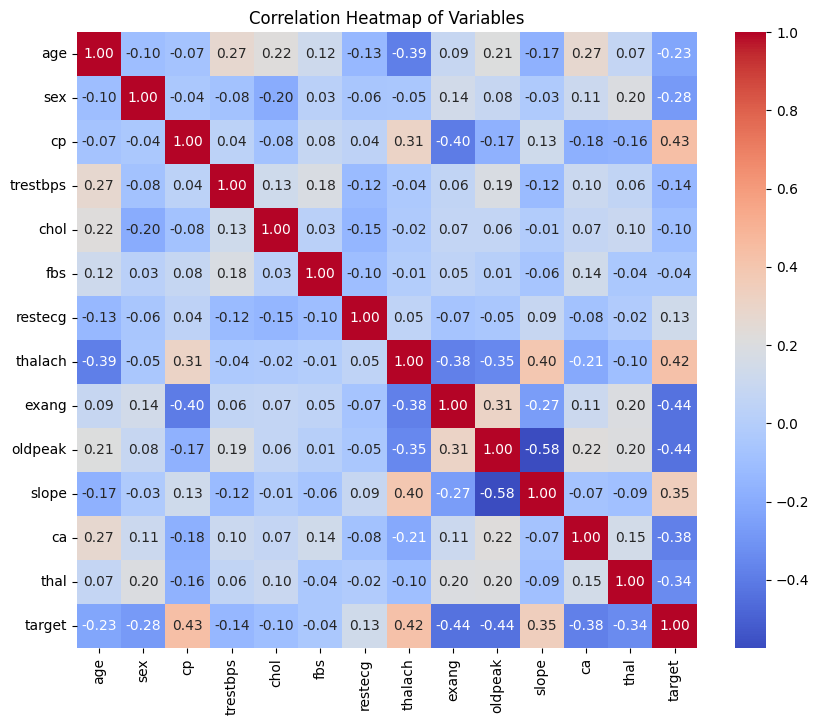

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Variables")
plt.show()

Pairwise Scatterplot (Pairplot)

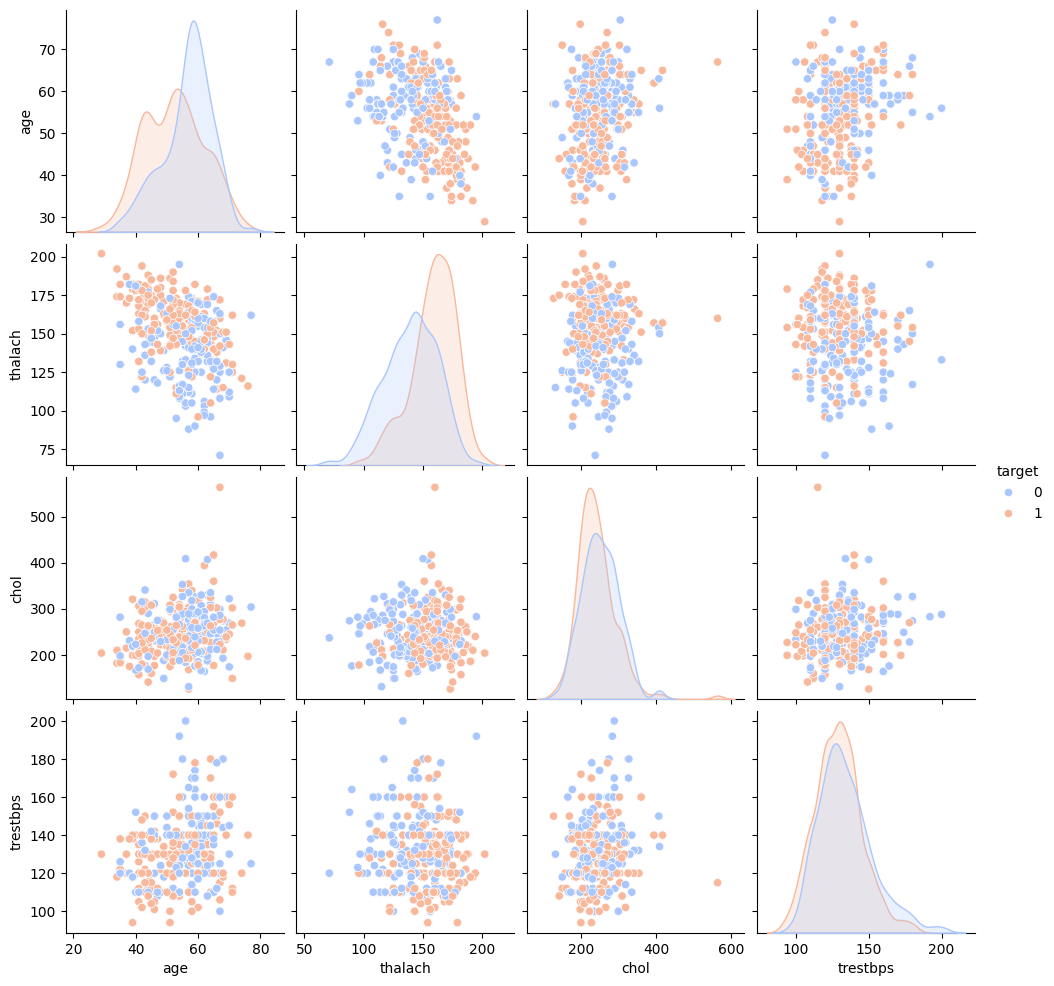

In [8]:
columns_to_plot = ["age", "thalach", "chol", "trestbps", "target"]
sns.pairplot(data[columns_to_plot], hue="target", palette="coolwarm")
plt.show()


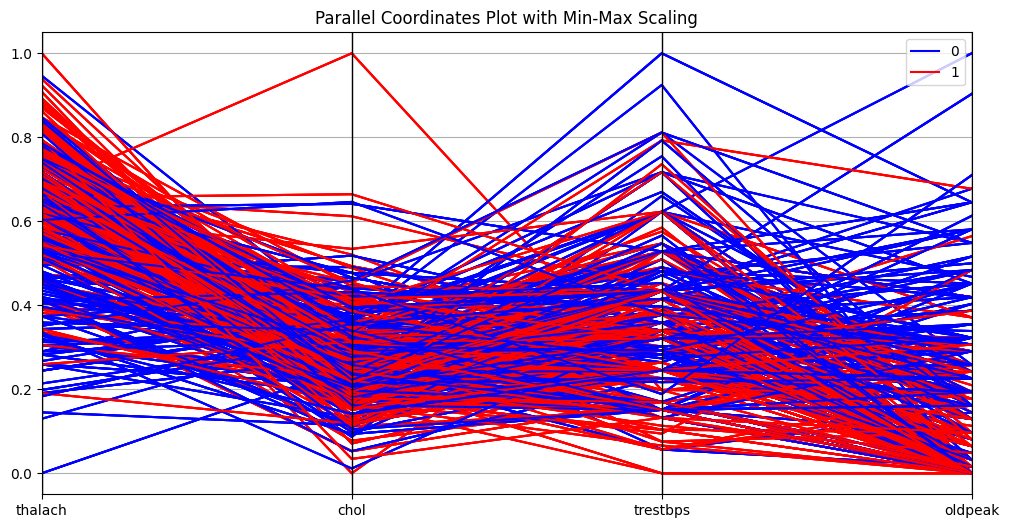

In [9]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[[ "thalach", "chol", "trestbps","oldpeak"]] = scaler.fit_transform(data[[ "thalach", "chol", "trestbps","oldpeak"]])

# Plot the scaled data
visualization_subset = data_scaled[[ "thalach", "chol", "trestbps","oldpeak", "target"]]
plt.figure(figsize=(12, 6))
parallel_coordinates(visualization_subset, class_column="target", color=["blue", "red"])
plt.title("Parallel Coordinates Plot with Min-Max Scaling")
plt.show()


Preprocessing and Split Dataset

Define features (X) and target variable (y)

In [10]:
X = data.drop(columns="target")
y = data["target"]


Identify numerical and categorical columns

In [11]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns


Preprocessing pipelines

In [12]:
from sklearn.preprocessing import  OneHotEncoder

Logistic Regression

In [13]:
log_reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols)
    ]
)

Random Forest

In [14]:
rf_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
    ], remainder="passthrough"
)

Split the dataset into training (80%) and testing (20%) subsets with stratification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Verify the class distribution in training and testing sets

In [16]:
print("Class distribution in y_train:", y_train.value_counts(normalize=True))
print("Class distribution in y_test:", y_test.value_counts(normalize=True))


Class distribution in y_train: target
1    0.513415
0    0.486585
Name: proportion, dtype: float64
Class distribution in y_test: target
1    0.512195
0    0.487805
Name: proportion, dtype: float64


Build Two Classification Models

1) Logistic Regression Model

In [17]:
log_reg_pipeline = Pipeline([
    ("preprocessor", log_reg_preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [22]:
rf_tuned_pipeline = Pipeline([
    ("preprocessor", rf_preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=5,   # Limit tree depth
        min_samples_split=10,  # Minimum samples required to split a node
        min_samples_leaf=5,   # Minimum samples required in a leaf node
        max_features="sqrt",  # Use square root of features at each split
        random_state=42))
])
rf_tuned_pipeline.fit(X_train, y_train)

# Calculate Training and Testing Accuracy for Tuned Random Forest
rf_tuned_train_acc = accuracy_score(y_train, rf_tuned_pipeline.predict(X_train))
rf_tuned_test_acc = accuracy_score(y_test, rf_tuned_pipeline.predict(X_test))



2)Random Forest Model

Calculate Training and Testing Accuracy

1)Logistic Regression Accuracy

In [23]:
log_reg_train_acc = accuracy_score(y_train, log_reg_pipeline.predict(X_train))
log_reg_test_acc = accuracy_score(y_test, log_reg_pipeline.predict(X_test))


2)Random Forest Accuracy

In [25]:
# In cell ipython-input-24-edd963a407e1
rf_train_acc = accuracy_score(y_train, rf_tuned_pipeline.predict(X_train))  # Use rf_tuned_pipeline
rf_test_acc = accuracy_score(y_test, rf_tuned_pipeline.predict(X_test))    # Use rf_tuned_pipeline

In [26]:
print("Logistic Regression Training Accuracy:", log_reg_train_acc)
print("Logistic Regression Testing Accuracy:", log_reg_test_acc)
print("Random Forest (Tuned) Training Accuracy:", rf_tuned_train_acc)
print("Random Forest (Tuned) Testing Accuracy:", rf_tuned_test_acc)

Logistic Regression Training Accuracy: 0.8463414634146341
Logistic Regression Testing Accuracy: 0.8097560975609757
Random Forest (Tuned) Training Accuracy: 0.9292682926829269
Random Forest (Tuned) Testing Accuracy: 0.9219512195121952


 Discussion on Model Performance

**Logistic Regression:**

Achieves a training accuracy of **84.63% **and testing accuracy of **80.98%,** indicating good generalization to unseen data. Logistic Regression performs well due to its ability to model linear relationships, but its performance is limited by its inability to capture complex, non-linear patterns in the data.

**Random Forest (Tuned):**

After applying hyperparameter tuning (e.g., limiting tree depth to max_depth=5 min_samples_leaf=5,min_samples_split=10 and using max_features="sqrt"), the Random Forest achieves a training accuracy of **92.93%** and testing accuracy of **92.20%.** These adjustments reduce overfitting while allowing the model to capture complex patterns effectively. Tuning parameters like tree depth prevent the model from memorizing training data, and limiting features at each split ensures better generalization.

.

Absolute Difference in Test Accuracy

In [27]:
accuracy_difference = abs(log_reg_test_acc - rf_tuned_test_acc)
print(f"Absolute Difference in Test Set Accuracy: {accuracy_difference:.2f}")

Absolute Difference in Test Set Accuracy: 0.11


Based on the absolute difference of 11% in test set accuracy, Model  **(Random Forest (Tuned))** clearly outperforms Model  (**Logistic Regression**).

**Random Forest (Tuned)** achieved a test accuracy of 92.20%, whereas Logistic Regression achieved a test accuracy of 80.98%.

The 11% difference indicates that **Random Forest (Tuned)** is significantly better at capturing complex, non-linear relationships in the data, which explains its superior performance.

While Logistic Regression remains a strong, interpretable model for linear relationships,** Random Forest (Tuned)** is the better choice for this dataset in terms of predictive performance. Its higher accuracy demonstrates that it is better suited to handle the intricate patterns and interactions between features in the dataset.

In conclusion, for this task, **Random Forest (Tuned)** provides the best model in terms of accuracy and generalization to unseen data. However, if model simplicity and interpretability are prioritized, Logistic Regression could still be a viable alternative, although it sacrifices predictive power for simplicity.

Perform permutation test

Plot the permutation distribution

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Test set true labels and predictions
# y_test = y_test.values  # Remove this line - y_test is already a NumPy array
y_pred_lr = log_reg_pipeline.predict(X_test)
# Replace 'rf_pipeline' with 'rf_tuned_pipeline'
y_pred_rf = rf_tuned_pipeline.predict(X_test)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Permutation test
n_permutations = 10000
accuracy_differences = []

# Compute observed difference in accuracy
observed_diff = accuracy_score(y_test, y_pred_rf) - accuracy_score(y_test, y_pred_lr)

for _ in range(n_permutations):
    # Shuffle the predicted labels
    y_pred_combined = np.concatenate([y_pred_lr, y_pred_rf])
    np.random.shuffle(y_pred_combined)

    # Split shuffled predictions into two groups
    shuffled_pred_lr = y_pred_combined[:len(y_pred_lr)]
    shuffled_pred_rf = y_pred_combined[len(y_pred_lr):]

    # Compute accuracy for each shuffled group
    shuffled_acc_lr = calculate_accuracy(y_test, shuffled_pred_lr)
    shuffled_acc_rf = calculate_accuracy(y_test, shuffled_pred_rf)

    # Record accuracy difference
    accuracy_differences.append(shuffled_acc_rf - shuffled_acc_lr)

# Null distribution of accuracy differences
accuracy_differences = np.array(accuracy_differences)

# Calculate p-value
p_value = np.mean(np.abs(accuracy_differences) >= np.abs(observed_diff))

# Print results
print(f"Observed Accuracy Difference: {observed_diff:.4f}")
print(f"P-value: {p_value:.4f}")

Observed Accuracy Difference: 0.1122
P-value: 0.0231


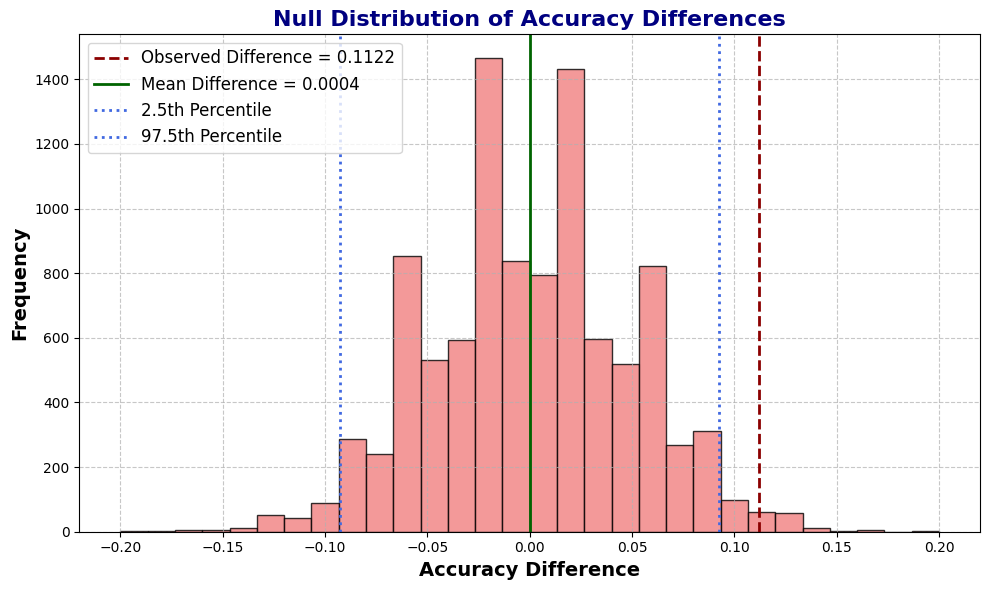

Mean of Null Distribution: 0.0004
Standard Deviation of Null Distribution: 0.0486
2.5th Percentile: -0.0927
97.5th Percentile: 0.0927


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Null distribution of accuracy differences
mean_diff = np.mean(accuracy_differences)
std_diff = np.std(accuracy_differences)
percentiles = np.percentile(accuracy_differences, [2.5, 97.5])

# Visualization of the null distribution with added styling
plt.figure(figsize=(10, 6))  # Increase figure size
plt.hist(accuracy_differences, bins=30, color='lightcoral', edgecolor='black', alpha=0.8)  # Changed color
plt.axvline(x=observed_diff, color='darkred', linestyle='--', linewidth=2, label=f"Observed Difference = {observed_diff:.4f}")
plt.axvline(x=mean_diff, color='darkgreen', linestyle='-', linewidth=2, label=f"Mean Difference = {mean_diff:.4f}")
plt.axvline(x=percentiles[0], color='royalblue', linestyle=':', linewidth=2, label="2.5th Percentile")
plt.axvline(x=percentiles[1], color='royalblue', linestyle=':', linewidth=2, label="97.5th Percentile")

# Title and labels with custom font size
plt.title("Null Distribution of Accuracy Differences", fontsize=16, fontweight='bold', color='navy')
plt.xlabel("Accuracy Difference", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')

# Adding a legend with a larger font
plt.legend(fontsize=12, loc='upper left')

# Grid with customized style
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Print distribution summary with formatted output
print(f"Mean of Null Distribution: {mean_diff:.4f}")
print(f"Standard Deviation of Null Distribution: {std_diff:.4f}")
print(f"2.5th Percentile: {percentiles[0]:.4f}")
print(f"97.5th Percentile: {percentiles[1]:.4f}")



**Observed Difference**
The observed difference in test set accuracy between Model A (Logistic Regression) and Model B (Random Forest) is 0.112 (11.2%).

**P-value**
From the permutation test, the p-value was 0.0231, which is below the significance threshold of 0.05.

**Conclusion**
The observed accuracy difference is statistically significant, meaning Random Forest outperforms Logistic Regression in this case.